In [125]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [126]:
results_path = Path("../../../results/classifiers")
STEP = "hp_search"

In [127]:
varying_hyperparameter_names = ["batch_size", "head_learning_rate", "l2_weight", "warmup_proportion"]

## Granular attributes classification

### Economic attributes

In [128]:
task = "economic_attributes_classification"
label_classes = [
    # 'economic__class_membership',
    'economic__education_level',
    'economic__occupation_profession',
    'economic__employment_status',
    'economic__income_wealth_economic_status',
    # 'economic__ecology_of_group',
]

#### Best hyperparameters?

In [129]:
trial_results_files = list(results_path.glob(f"{task}/**/{STEP}/**/trial_results.csv"))

In [130]:
trial_results = pd.concat(
    {f.parts[-4:-1]: pd.read_csv(f) for f in trial_results_files},
)
trial_results.reset_index(level=[0, 1, 2], names=["model", "strategy", "fold"], inplace=True)

In [131]:
trial_results_sum = trial_results.groupby(["model", "strategy", *varying_hyperparameter_names])["f1"].mean().reset_index()

In [132]:
# get row with max F1 for each model and strategy
trial_results_sum.groupby(["model", "strategy"])[["f1", *varying_hyperparameter_names]].apply(lambda x: x.loc[x["f1"].idxmax()]).reset_index()

,model,strategy,f1,batch_size,head_learning_rate,l2_weight,warmup_proportion
0,google--embeddinggemma-300m,mention_text,0.605311,"(16, 4)",0.0001,0.015,0.1
1,nomic-ai--modernbert-embed-base,mention_text,0.871875,"(8, 16)",0.0030,0.200,0.1
2,sentence-transformers--all-mpnet-base-v2,mention_text,0.790788,"(8, 8)",0.0030,0.200,0.1


In [133]:
trial_results[['batch_size_body', 'batch_size_head']] = trial_results.batch_size.apply(lambda x: eval(x) if isinstance(x, str) else x).apply(pd.Series)
trial_results.query("""\
    model == "sentence-transformers--all-mpnet-base-v2" and \
    batch_size_body == 8 and batch_size_head == 8 and \
    head_learning_rate == 0.003 and \
    l2_weight == 0.200 and \
    warmup_proportion == 0.10 \
""")

,model,strategy,fold,trial_id,started_at,finished_at,duration,batch_size,head_learning_rate,l2_weight,warmup_proportion,f1,batch_size_body,batch_size_head
3,sentence-transformers--all-mpnet-base-v2,mention_text,fold02,3,2026-02-05T10:59:16,2026-02-05T11:00:20,64,"(8, 8)",0.003,0.2,0.1,0.711994,8,8
10,sentence-transformers--all-mpnet-base-v2,mention_text,fold02,10,2026-02-05T11:07:54,2026-02-05T11:08:58,63,"(8, 8)",0.003,0.2,0.1,0.711994,8,8
11,sentence-transformers--all-mpnet-base-v2,mention_text,fold02,11,2026-02-05T11:08:58,2026-02-05T11:10:03,65,"(8, 8)",0.003,0.2,0.1,0.711994,8,8
12,sentence-transformers--all-mpnet-base-v2,mention_text,fold02,12,2026-02-05T11:10:03,2026-02-05T11:11:06,62,"(8, 8)",0.003,0.2,0.1,0.711994,8,8
3,sentence-transformers--all-mpnet-base-v2,mention_text,fold03,3,2026-02-05T12:40:34,2026-02-05T12:41:39,65,"(8, 8)",0.003,0.2,0.1,0.720238,8,8
3,sentence-transformers--all-mpnet-base-v2,mention_text,fold05,3,2026-02-05T16:22:05,2026-02-05T16:23:11,66,"(8, 8)",0.003,0.2,0.1,0.702354,8,8
3,sentence-transformers--all-mpnet-base-v2,mention_text,fold01,3,2026-02-05T08:56:33,2026-02-05T08:57:41,68,"(8, 8)",0.003,0.2,0.1,0.758507,8,8
3,sentence-transformers--all-mpnet-base-v2,mention_text,fold04,3,2026-02-05T14:28:22,2026-02-05T14:29:45,82,"(8, 8)",0.003,0.2,0.1,0.917398,8,8
10,sentence-transformers--all-mpnet-base-v2,mention_text,fold04,10,2026-02-05T14:40:08,2026-02-05T14:41:16,68,"(8, 8)",0.003,0.2,0.1,0.917398,8,8
11,sentence-transformers--all-mpnet-base-v2,mention_text,fold04,11,2026-02-05T14:41:16,2026-02-05T14:42:32,75,"(8, 8)",0.003,0.2,0.1,0.917398,8,8


#### Model evaluation

::: {.callout-tip title="model selection"}

I also checked aveage results for `nomic-ai--modernbert-embed-base` but the score rpeorted above is a n outlier -- `sentence-transformers--all-mpnet-base-v2` performs more consistently across categories and folds.

::: 

In [137]:
# model = "nomic-ai--modernbert-embed-base"
model = "sentence-transformers--all-mpnet-base-v2"

In [ ]:
results_dir = results_path / task / STEP / "setfit" / model

df = pd.concat({
    fp.parts[-5:-1]: pd.read_json(fp).T.reset_index(level=0, names="what") 
    for fp in results_dir.glob("**/eval_results.json")
})
df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)

In [141]:
metrics = ["weighted avg", "macro avg", "micro avg", "samples avg"]
pdat = df.query("what not in @metrics").copy()
pdat["what"] = pdat["what"]\
    .str.replace("economic__", "")\
    .str.replace("_status", " status")\
    .str.replace("_level", "")\
    .str.replace("_", "/")

pdat.groupby("what")["f1-score"].agg(['mean', 'std']).sort_values('mean', ascending=False).apply(lambda x: f"{x['mean']:.3f}±{x['std']:.3f}", axis=1)

what
education                        0.942±0.089
occupation/profession            0.787±0.107
income/wealth/economic status    0.751±0.093
employment status                0.721±0.151
dtype: object

/tmp/ipykernel_2500622/1071733072.py:13: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipykernel_2500622/1071733072.py:13: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


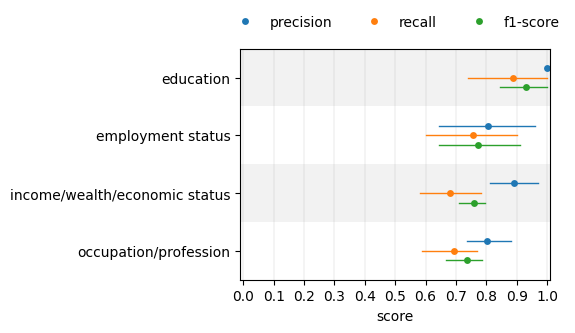

In [71]:
pdat = pdat.melt(id_vars=["what", "fold"], value_vars=["precision", "recall", "f1-score"], var_name="metric", value_name="value")

plt.figure(figsize=(4, 3))

# add grey horizontal stripes at alternating y positions
for i in range(pdat.what.nunique()):
    if i % 2 == 0:
        plt.gca().axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

ls = '-' # (0, (5, 10))
plt.grid(axis="x", which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

sns.pointplot(
    data=pdat,
    y="what",
    x="value",

    hue="metric",
    dodge=1/3,
    #color='black',
    
    linestyles='none',
    scale=2/3,
    errwidth=1,
    # markersize=3,

    errorbar='ci',
    # capsize=.05,
    # err_kws={'linewidth': .75},

    # legend=False,
    seed=42
)
# add bold title and labels
# plt.title(metric, fontweight='bold')
plt.xlabel("score")
plt.ylabel("")
plt.xlim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.1, 0.1))

# place legend below plot
plt.legend(title=None, bbox_to_anchor=(0.5, +1.2), loc='upper center', ncol=3, frameon=False)
# plt.tight_layout()

plt.show()

#### Error analysis

- get predicted labels for val sets of different folds
- compute misclassification rates across models and strategies
- review mis-classified instances

In [72]:
key_cols = ['fold', 'mention_id', 'text', 'mention', 'span']

preds_df = pd.concat({
    fp.parts[-4:-1]: pd.read_pickle(fp)
    for fp in results_dir.glob("**/eval_predictions.pkl")
})
preds_df.reset_index(level=[0,1,2], names=["model_name", "strategy", "fold"], inplace=True)
# get index of column "span"
i = preds_df.columns.get_loc("span")
key_cols = preds_df.columns[:i+1]
preds_df_long = preds_df.melt(id_vars=key_cols, var_name="attribute", value_name="value")

preds_df_long['what'] = preds_df_long['attribute'].str.extract('^(prob|pred|error)_.+$')
preds_df_long.loc[preds_df_long['what'].isnull(), 'what'] = 'label'
preds_df_long['attribute'] = preds_df_long['attribute'].str.replace('^(prob|pred|error)_', '', regex=True)

preds_df = preds_df_long.pivot(index=[*key_cols, 'attribute'], columns='what', values='value').reset_index()
preds_df.columns.name = None

preds_df['label'] = preds_df['label'].astype(int)
preds_df['pred'] = preds_df['pred'].astype(int)
preds_df['prob'] = preds_df['prob'].astype(float)
preds_df['error'] = preds_df['error'].astype(bool)

In [73]:
# compute error rate
id_cols = ['mention_id', 'text', 'mention', 'span', 'attribute', 'label']
error_rates_df = preds_df.groupby(id_cols, observed=False).agg({'error': 'mean'}).reset_index()

In [74]:
error_rates_df.sort_values('error', ascending=False, inplace=True)

In [75]:
highlight = lambda text, mention: text.replace(mention, '\u001B[30m\u001B[43m'+mention+'\033[0m')

threshold = 1/3
label_id_2_error_type = {0: 'false positives', 1: 'false negatives'}
for a, tmp in error_rates_df.groupby('attribute'):
    print(f"\033[1m{a}\033[0m")
    for l, subdf in tmp.groupby('label'):
        # print attribute name in bold
        print(f"  ~> \033[1m\033[3m{label_id_2_error_type[l]}\033[0m")
        for i, row in subdf[subdf['error'] > threshold].head(20).iterrows():
            highlighted_text = highlight(row['text'], row['mention'])
            print(f"  - {row['mention_id'].rjust(22)} ({row['error']:.2f}):  {highlighted_text}")
        print()

economic__education_level
  ~> false positives

  ~> false negatives
  -  14110_201904-203887-1 (1.00):  People who are not well, especially boys, are getting worse.
  -  11110_200209-393006-1 (1.00):  Students with children have great difficulties bringing the economy together.
  -  53110_199706-276868-1 (1.00):  6. A reduction of the maximum size of the larger second-level schools to between 350 and 500 pupils.

economic__employment_status
  ~> false positives
  -  92436_200509-360693-2 (1.00):  It is necessary to expand the lustration, to disclose all peer-related special services officers and secret collaborators.
  -   62110_201510-97858-2 (1.00):  Canadians are a people united by cooperation, hard work, and mutual respect.
  -   43110_198710-98339-1 (1.00):  In the face of any ideological differences, promoting the cooperation of all the green forces is our primary concern.
  -  31110_201206-217612-1 (1.00):  Careers of cultural workers and French foreign language teachers.
  -  

### Non-economic attributes

In [103]:
task = "noneconomic_attributes_classification"
label_classes = [
    'noneconomic__age',
    'noneconomic__crime',
    'noneconomic__ethnicity',
    'noneconomic__family',
    'noneconomic__gender_sexuality',
    'noneconomic__health',
    'noneconomic__nationality',
    'noneconomic__place_location',
    'noneconomic__religion',
    'noneconomic__shared_values_mentalities',
]

#### Best hyperparameters?

In [104]:
trial_results_files = list(results_path.glob(f"{task}/**/{STEP}/**/trial_results.csv"))

In [105]:
trial_results = pd.concat(
    {f.parts[-4:-1]: pd.read_csv(f) for f in trial_results_files},
)
trial_results.reset_index(level=[0, 1, 2], names=["model", "strategy", "fold"], inplace=True)

In [106]:
trial_results_sum = trial_results.groupby(["model", "strategy", *varying_hyperparameter_names])["f1"].mean().reset_index()

In [107]:
# get row with max F1 for each model and strategy
trial_results_sum.groupby(["model", "strategy"])[["f1", *varying_hyperparameter_names]].apply(lambda x: x.loc[x["f1"].idxmax()]).reset_index()

,model,strategy,f1,batch_size,head_learning_rate,l2_weight,warmup_proportion
0,google--embeddinggemma-300m,mention_text,0.607652,"(8, 4)",0.0001,0.015,0.10
1,nomic-ai--modernbert-embed-base,mention_text,0.858777,"(32, 4)",0.0300,0.015,0.15
2,sentence-transformers--all-mpnet-base-v2,mention_text,0.797181,"(8, 4)",0.0100,0.200,0.10


In [123]:
trial_results.groupby(["model", "strategy", *varying_hyperparameter_names]).agg(f1_mean=('f1', 'mean'), f1_std=('f1', 'std'), n=('f1', 'size')).reset_index().sort_values('f1_mean', ascending=False)

,model,strategy,batch_size,head_learning_rate,l2_weight,warmup_proportion,f1_mean,f1_std,n
33,nomic-ai--modernbert-embed-base,mention_text,"(32, 4)",0.0300,0.015,0.15,0.858777,NaN,1
36,nomic-ai--modernbert-embed-base,mention_text,"(32, 8)",0.0300,0.015,0.15,0.816529,NaN,1
57,sentence-transformers--all-mpnet-base-v2,mention_text,"(8, 4)",0.0100,0.200,0.10,0.797181,NaN,1
40,nomic-ai--modernbert-embed-base,mention_text,"(8, 4)",0.0300,0.015,0.10,0.791129,NaN,1
52,sentence-transformers--all-mpnet-base-v2,mention_text,"(32, 4)",0.0300,0.015,0.15,0.789560,NaN,1
51,sentence-transformers--all-mpnet-base-v2,mention_text,"(32, 4)",0.0100,0.010,0.15,0.788394,0.035650,12
54,sentence-transformers--all-mpnet-base-v2,mention_text,"(32, 8)",0.0100,0.010,0.15,0.781241,NaN,1
43,sentence-transformers--all-mpnet-base-v2,mention_text,"(16, 16)",0.0030,0.010,0.10,0.773594,NaN,1
48,sentence-transformers--all-mpnet-base-v2,mention_text,"(16, 8)",0.0100,0.010,0.15,0.768419,0.071974,11
55,sentence-transformers--all-mpnet-base-v2,mention_text,"(32, 8)",0.0300,0.015,0.10,0.766632,0.060566,5


In [124]:
trial_results[['batch_size_body', 'batch_size_head']] = trial_results.batch_size.apply(lambda x: eval(x) if isinstance(x, str) else x).apply(pd.Series)
trial_results.query("""\
    model == "sentence-transformers--all-mpnet-base-v2" and \
    batch_size_body == 32 and batch_size_head == 4 and \
    head_learning_rate == 0.01 and \
    l2_weight == 0.01 and \
    warmup_proportion == 0.15 \
""")

,model,strategy,fold,trial_id,started_at,finished_at,duration,batch_size,head_learning_rate,l2_weight,warmup_proportion,f1,batch_size_body,batch_size_head
8,sentence-transformers--all-mpnet-base-v2,mention_text,fold02,8,2026-02-05T11:07:10,2026-02-05T11:08:24,74,"(32, 4)",0.01,0.01,0.15,0.690619,32,4
8,sentence-transformers--all-mpnet-base-v2,mention_text,fold03,8,2026-02-05T13:05:07,2026-02-05T13:06:21,73,"(32, 4)",0.01,0.01,0.15,0.776178,32,4
11,sentence-transformers--all-mpnet-base-v2,mention_text,fold03,11,2026-02-05T13:08:48,2026-02-05T13:10:05,76,"(32, 4)",0.01,0.01,0.15,0.776178,32,4
12,sentence-transformers--all-mpnet-base-v2,mention_text,fold03,12,2026-02-05T13:10:05,2026-02-05T13:11:18,73,"(32, 4)",0.01,0.01,0.15,0.776178,32,4
8,sentence-transformers--all-mpnet-base-v2,mention_text,fold05,8,2026-02-05T17:02:29,2026-02-05T17:04:01,91,"(32, 4)",0.01,0.01,0.15,0.834855,32,4
8,sentence-transformers--all-mpnet-base-v2,mention_text,fold01,8,2026-02-05T09:02:40,2026-02-05T09:04:30,109,"(32, 4)",0.01,0.01,0.15,0.794595,32,4
10,sentence-transformers--all-mpnet-base-v2,mention_text,fold01,10,2026-02-05T09:06:07,2026-02-05T09:07:57,109,"(32, 4)",0.01,0.01,0.15,0.794595,32,4
11,sentence-transformers--all-mpnet-base-v2,mention_text,fold01,11,2026-02-05T09:07:57,2026-02-05T09:09:46,108,"(32, 4)",0.01,0.01,0.15,0.794595,32,4
12,sentence-transformers--all-mpnet-base-v2,mention_text,fold01,12,2026-02-05T09:09:46,2026-02-05T09:11:32,106,"(32, 4)",0.01,0.01,0.15,0.794595,32,4
13,sentence-transformers--all-mpnet-base-v2,mention_text,fold01,13,2026-02-05T09:11:32,2026-02-05T09:13:17,104,"(32, 4)",0.01,0.01,0.15,0.794595,32,4


#### Model evaluation

::: {.callout-tip title="model selection"}

I also checked aveage results for `nomic-ai--modernbert-embed-base` but the score rpeorted above is a n outlier -- `sentence-transformers--all-mpnet-base-v2` performs more consistently across categories and folds.

::: 

In [108]:
# model = "nomic-ai--modernbert-embed-base"
model = "sentence-transformers--all-mpnet-base-v2"

In [109]:
results_dir = results_path / task / STEP / "setfit" / model

df = pd.concat({
    fp.parts[-5:-1]: pd.read_json(fp).T.reset_index(level=0, names="what") 
    for fp in results_dir.glob("**/eval_results.json")
})
df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)

In [110]:
metrics = ["weighted avg", "macro avg", "micro avg", "samples avg"]
pdat = df.query("what not in @metrics").copy()
pdat["what"] = pdat["what"]\
    .str.replace("noneconomic__", "")\
    .str.replace("shared_", "shared ")\
    .str.replace("_", "/")

pdat.groupby("what")["f1-score"].agg(['mean', 'std']).sort_values('mean', ascending=False).apply(lambda x: f"{x['mean']:.3f}±{x['std']:.3f}", axis=1)

what
ethnicity                    0.921±0.074
family                       0.905±0.136
age                          0.872±0.033
nationality                  0.819±0.059
gender/sexuality             0.765±0.257
crime                        0.764±0.209
religion                     0.759±0.223
shared values/mentalities    0.753±0.062
place/location               0.750±0.186
health                       0.732±0.154
dtype: object

/tmp/ipykernel_2500622/4284136641.py:14: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipykernel_2500622/4284136641.py:14: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


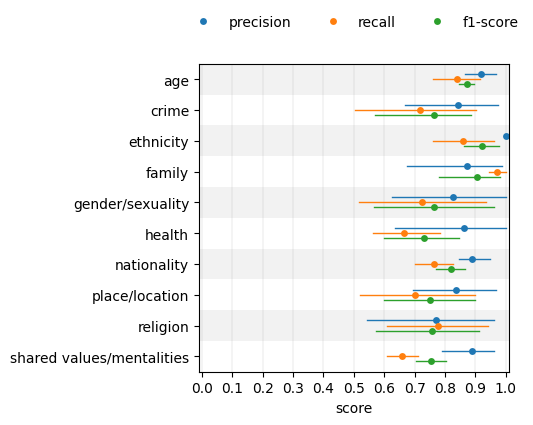

In [111]:
pdat = pdat.melt(id_vars=["what", "fold"], value_vars=["precision", "recall", "f1-score"], var_name="metric", value_name="value")

n_ys = pdat.what.nunique()
plt.figure(figsize=(4, n_ys/2.5))

# add grey horizontal stripes at alternating y positions
for i in range(n_ys):
    if i % 2 == 0:
        plt.gca().axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

ls = '-' # (0, (5, 10))
plt.grid(axis="x", which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

sns.pointplot(
    data=pdat,
    y="what",
    x="value",

    hue="metric",
    dodge=1/3,
    #color='black',
    
    linestyles='none',
    scale=2/3,
    errwidth=1,
    # markersize=3,

    errorbar='ci',
    # capsize=.05,
    # err_kws={'linewidth': .75},

    # legend=False,
    seed=42
)
# add bold title and labels
# plt.title(metric, fontweight='bold')
plt.xlabel("score")
plt.ylabel("")
plt.xlim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.1, 0.1))

# place legend below plot
plt.legend(title=None, bbox_to_anchor=(0.5, +1.2), loc='upper center', ncol=3, frameon=False)
# plt.tight_layout()

plt.show()

#### Error analysis

- get predicted labels for val sets of different folds
- compute misclassification rates across models and strategies
- review mis-classified instances

In [112]:
key_cols = ['fold', 'mention_id', 'text', 'mention', 'span']

preds_df = pd.concat({
    fp.parts[-4:-1]: pd.read_pickle(fp)
    for fp in results_dir.glob("**/eval_predictions.pkl")
})
preds_df.reset_index(level=[0,1,2], names=["model_name", "strategy", "fold"], inplace=True)
# get index of column "span"
i = preds_df.columns.get_loc("span")
key_cols = preds_df.columns[:i+1]
preds_df_long = preds_df.melt(id_vars=key_cols, var_name="attribute", value_name="value")

preds_df_long['what'] = preds_df_long['attribute'].str.extract('^(prob|pred|error)_.+$')
preds_df_long.loc[preds_df_long['what'].isnull(), 'what'] = 'label'
preds_df_long['attribute'] = preds_df_long['attribute'].str.replace('^(prob|pred|error)_', '', regex=True)

preds_df = preds_df_long.pivot(index=[*key_cols, 'attribute'], columns='what', values='value').reset_index()
preds_df.columns.name = None

preds_df['label'] = preds_df['label'].astype(int)
preds_df['pred'] = preds_df['pred'].astype(int)
preds_df['prob'] = preds_df['prob'].astype(float)
preds_df['error'] = preds_df['error'].astype(bool)

In [113]:
# compute error rate
id_cols = ['mention_id', 'text', 'mention', 'span', 'attribute', 'label']
error_rates_df = preds_df.groupby(id_cols, observed=False).agg({'error': 'mean'}).reset_index()

In [114]:
# TODO: error rates don't make senses with one classifier and distinct eval (test) sets per fold
error_rates_df.error.value_counts()

error
0.0    5852
1.0     148
Name: count, dtype: int64

In [115]:
error_rates_df.sort_values('error', ascending=False, inplace=True)

In [116]:
highlight = lambda text, mention: text.replace(mention, '\u001B[30m\u001B[43m'+mention+'\033[0m')

threshold = 1/3
label_id_2_error_type = {0: 'false positives', 1: 'false negatives'}
for a, tmp in error_rates_df.groupby('attribute'):
    print(f"\033[1m{a}\033[0m")
    for l, subdf in tmp.groupby('label'):
        # print attribute name in bold
        print(f"  ~> \033[1m\033[3m{label_id_2_error_type[l]}\033[0m")
        for i, row in subdf[subdf['error'] > threshold].head(20).iterrows():
            highlighted_text = highlight(row['text'], row['mention'])
            print(f"  - {row['mention_id'].rjust(22)} ({row['error']:.2f}):  {highlighted_text}")
        print()

noneconomic__age
  ~> false positives
  -  11320_201409-397483-1 (1.00):  Everyone working in the elderly care sector should be trained in dementia and multi-disease.
  - 171101_200306-303319-1 (1.00):  In 40% of the families of these young people, the characteristics of the reference group of their children are unknown, as well as the activities they regularly carry out.
  -  82720_201310-117539-1 (1.00):  Only those who lead an orderly life and educate children properly deserve support.
  -   42110_198611-03946-1 (1.00):  Powerful cliques behind and within the old parties are heading towards the Great Coalition.
  -   21914_198510-27676-1 (1.00):  Generations of Flemish fighters have not given the best of themselves so that Flanders would soon become another American protectorate, or be condemned to another island in the Goel archipelago.
  -  11110_200209-393006-1 (1.00):  Students with children have great difficulties bringing the economy together.

  ~> false negatives
  -  41320_